In [1]:
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

['data/names/Irish.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Arabic.txt', 'data/names/Spanish.txt']
Slusarski
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).cuda()


In [4]:
n_hidden = 128
n_epochs = 2000000
print_every = 10000
plot_every = 1000
learning_rate = 0.003 # If you set this too high, it might explode. If too low, it might not learn

def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [5]:
rnn = RNN(n_letters, n_hidden, n_categories)
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
rnn = rnn.cuda()

In [6]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [7]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [8]:
start = time.time()
for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = randomTrainingPair()
    output, loss = train(category_tensor.cuda(), line_tensor.cuda())
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        #print(current_loss)
        current_loss = 0

10000 0% (0m 17s) 2.8553 Paredes / Greek ✗ (Spanish)
20000 1% (0m 35s) 0.6281 Kowalski / Polish ✓
30000 1% (0m 53s) 2.0586 Silveira / Italian ✗ (Portuguese)
40000 2% (1m 11s) 1.9347 Elms / Greek ✗ (English)
50000 2% (1m 29s) 0.2448 Fujimaki / Japanese ✓
60000 3% (1m 46s) 1.1967 Egamberdiev / Russian ✓
70000 3% (2m 4s) 1.7628 Nowak / Polish ✗ (Czech)
80000 4% (2m 22s) 0.4833 Diep / Vietnamese ✓
90000 4% (2m 40s) 2.6343 Quasninsky / Polish ✗ (Czech)
100000 5% (2m 58s) 2.0955 Sturm / Arabic ✗ (German)
110000 5% (3m 16s) 0.9023 Taylor / Scottish ✓
120000 6% (3m 34s) 0.2056 Gan / Chinese ✓
130000 6% (3m 52s) 0.2048 Fujikage / Japanese ✓
140000 7% (4m 10s) 0.5834 Kerper / German ✓
150000 7% (4m 27s) 1.3919 Kang / Chinese ✗ (Korean)
160000 8% (4m 45s) 0.4210 Dounias / Greek ✓
170000 8% (5m 3s) 5.0386 Auttenberg / English ✗ (Polish)
180000 9% (5m 21s) 0.6011 Luu / Vietnamese ✓
190000 9% (5m 39s) 0.0286 Kumasaka / Japanese ✓
200000 10% (5m 57s) 0.3992 Stenger / German ✓
210000 10% (6m 15s) 0.17

1660000 83% (46m 15s) 1.0092 Hill / Scottish ✓
1670000 83% (46m 27s) 1.0682 Bustos / Spanish ✓
1680000 84% (46m 40s) 0.4678 Manco / Italian ✓
1690000 84% (46m 52s) 1.5170 Han / Chinese ✗ (Vietnamese)
1700000 85% (47m 5s) 0.0001 Zimenkov / Russian ✓
1710000 85% (47m 18s) 0.1052 Shim / Korean ✓
1720000 86% (47m 31s) 5.2341 Remmert / Dutch ✗ (Russian)
1730000 86% (47m 43s) 0.3157 Jirdetsky / Russian ✓
1740000 87% (47m 56s) 0.1476 Mckay / Scottish ✓
1750000 87% (48m 9s) 1.1180 Slusarski / Polish ✓
1760000 88% (48m 22s) 0.4711 Mo / Korean ✓
1770000 88% (48m 35s) 0.2889 Letsos / Greek ✓
1780000 89% (48m 47s) 1.5430 Vanstone / Scottish ✗ (English)
1790000 89% (49m 0s) 0.3425 Sacco / Italian ✓
1800000 90% (49m 13s) 0.0272 Endolov / Russian ✓
1810000 90% (49m 26s) 0.1611 Coilean / Irish ✓
1820000 91% (49m 38s) 0.5966 Hughes / Scottish ✓
1830000 91% (49m 51s) 0.3632 Tong / Vietnamese ✓
1840000 92% (50m 4s) 0.1825 Tieu / Vietnamese ✓
1850000 92% (50m 17s) 0.0794 Patselas / Greek ✓
1860000 93% (50

In [9]:
torch.save(rnn, './checkpoints/char-rnn-classification.pt')

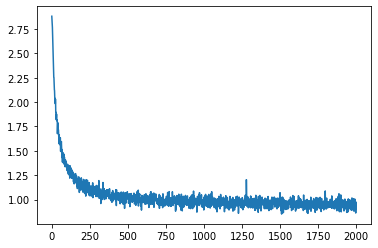

In [10]:
plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_941176/2917715247.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_941176/2917715247.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


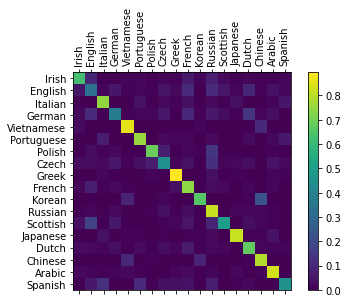

In [11]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].cuda(), hidden.cuda())
        
    return output.cpu()

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [12]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.16) Russian
(-1.97) Czech
(-4.78) English

> Jackson
(-0.75) Russian
(-0.98) English
(-2.36) Czech

> Satoshi
(-0.49) Italian
(-1.32) Japanese
(-2.99) Arabic


In [13]:
predict('Chang')


> Chang
(-0.21) Korean
(-2.42) Vietnamese
(-2.46) Chinese


In [14]:
from sklearn.metrics import roc_auc_score
from torch.nn.functional import one_hot
y_gts = []
y_preds = []
for category, input_lines in category_lines.items():
    category_tensor = torch.LongTensor([all_categories.index(category)])
    categroy_one_hot_tensor = one_hot(category_tensor, num_classes=n_categories)
    for input_line in input_lines:
        #print(input_line)
        output = evaluate(lineToTensor(input_line))
        y_gts.append(categroy_one_hot_tensor.squeeze().detach().numpy())
        y_preds.append(torch.exp(output).squeeze().detach().numpy())


In [15]:
roc_auc_score(y_gts, y_preds)

0.9691760632175619